# Perturbation Theory

In this notebook, we compare the perturbation theory calculations with the ones from the vGH Ansatz.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import time, os, sys, gc

import h5py 

import svgutils.transform as sg 
import sys 

import matplotlib.patches as patches

from scipy.integrate import solve_ivp

import class_energy as energy
import class_equations_of_motion as eom 

import class_handle_input as h_in
import class_handle_wavefunctions as h_wavef

import class_visualization as vis
import class_mass_size as mass_size

### Self Energy expression

We compute the self-energy obtained from the perturbative Ansatz and find the energy that fulfills the self-consistent equation.

In [2]:
def integrate_self_energy(V_0, tx, ty, B, E):
    E_self = lambda kx, ky: (2*V_0**2)/(4*np.pi**2)*(1-np.cos(kx)*np.cos(ky))/(B-E-2*tx*np.cos(kx)-2*ty*np.cos(ky))
    E_self_int = scipy.integrate.dblquad(E_self, -np.pi,np.pi, -np.pi,np.pi)
    return E_self_int

def find_Ep(V_0, tx, ty, B, E_guess):
    E_self_int = lambda E: E+integrate_self_energy(V_0, tx, ty, B, E-2*tx-2*ty)[0]
    E_min = scipy.optimize.fsolve(E_self_int, [E_guess])
    return E_min

def guess_Ep(V_0):
    return -0.004649*V_0**2-0.07471*V_0+0.8718

Here we define functions that compute the vGH and perturbative energies for different potentials.

In [3]:
def quick_pot_scan(params, V_0_arr, folder):
    h5_io_object = h_in.io_hdf5()

    print('\nvGH Calculations:')
    E_arr = np.zeros(len(V_0_arr), dtype=complex)
    for i in range(len(V_0_arr)):
        print('V0 =', V_0_arr[i])
        params["V_0"] = V_0_arr[i]

        eom_object = eom.eom(params=params)
        wavefunc_object = h_wavef.wavefunctions(params=params)
        wfn_manip = h_wavef.wavefunc_operations(params=params)
        ''' 
        Init wavefunction
        '''
        psi_init = wavefunc_object.create_init_wavefunction(params['init_choice'])
        psi_init = wfn_manip.reshape_one_dim(psi_init)
        ''' 
        Imaginary Time Propagation
        '''
        psi, E_evo, epsilon_evo = eom_object.solve_for_fixed_params_imag_time_prop_new(psi_init)
        E_arr[i] = E_evo[-1]

        h5_io_object.save_calculation_run(psi, E_evo, epsilon_evo, params, folder)

    return E_arr

def pert_pot_scan(params, V_0_arr):
    print('\nPerturbative Calculations:')
    E_arr = np.zeros(len(V_0_arr), dtype=complex)
    for i in range(len(V_0_arr)):
        E_min = find_Ep(V_0_arr[i], params["tx"], params["ty"], params["B"], guess_Ep(V_0_arr[i]))
        E_arr[i] = E_min[0]
        print('V0 =', V_0_arr[i], ', E =', E_arr[i])
        
    return E_arr

def get_Ep_from_E_vGH(E_vGH, tx, ty):
    return E_vGH+2*tx+2*ty

def get_E_from_Ep(E_vGH, tx, ty):
    return E_vGH-2*tx-2*ty

def get_E_arr(V_0_range, folder, check_sys, check_sym):
    h5_io_object = h_in.io_hdf5()
    
    E_arr = np.zeros(len(V_0_range), dtype=complex)
    for i in range(len(V_0_range)):
        check_sys_n = check_sys+'_V0_'+str(V_0_range[i])
        file_list = [f for f in os.listdir(folder) if check_sys_n in f and check_sym in f]
        
        if len(file_list) > 1: 
            break
        for file in file_list:
            file_name = folder+file
            psi, params = h5_io_object.get_psi(file_name)

            energy_object = energy.energy(params=params)
            E, E_T, E_B, E_V = energy_object.calc_energy(psi)
            E_arr[i] = E
    return E_arr

### Define the calculation parameters

In [4]:
params = {"n": 256,
"M": 36,
"Mx": 16,
"Mx_display": 4,
"converge_new_lattice": "no",
"My": 16,
"My_display": 4,
"B": 1.0,
"tx": 100,
"ty": 100,
"V_0": 150.0,
"qx": 0,
"qy": 0,
"init_choice": "uniform",
"external_wf_tag": " ",
"excitation_no": 11,
"angle_pattern": [0,0,0,0],
"V_0_pattern": [0,0,0,0],
"n_states": 0,
"path_to_input_wavefunction": " ",
"dt": 0.001,
"tol": 1e-10}

x = (2*np.pi/params["n"])*np.arange(params["n"])

''' 
I/O Object
'''
h5_io_object = h_in.io_hdf5()

### Perturbation Energies

In [9]:
V_0_range1 = np.linspace(0,10,21) 
V_0_range2 = np.linspace(15,100,18)

V_0_range = np.append(V_0_range1, V_0_range2)

In [92]:
params["B"] = 1.0
params["tx"] = 10
params["ty"] = 190
Ep_pert3_B_1 = pert_pot_scan(params, V_0_range)
E_pert3_B_1 = get_E_from_Ep(Ep_pert3_B_1, params["tx"], params["ty"])

params["B"] = 200.0
params["tx"] = 10
params["ty"] = 190
Ep_pert3_B_200 = pert_pot_scan(params, V_0_range)
E_pert3_B_200 = get_E_from_Ep(Ep_pert3_B_200, params["tx"], params["ty"])


Perturbative Calculations:
V0 = 0.00201 , E = (-5.6919597318058784e-08+0j)
V0 = 0.5 , E = (-0.0035217971154689314+0j)
V0 = 1.0 , E = (-0.0140827860014545+0j)
V0 = 1.5 , E = (-0.031669827978478636+0j)
V0 = 2.0 , E = (-0.056261249840517905+0j)
V0 = 2.5 , E = (-0.08782716593503433+0j)
V0 = 3.0 , E = (-0.12632990167273453+0j)
V0 = 3.5 , E = (-0.1717244956620243+0j)
V0 = 4.0 , E = (-0.22395925648184234+0j)
V0 = 4.5 , E = (-0.28297635123216236+0j)
V0 = 5.0 , E = (-0.3487124057756977+0j)
V0 = 5.5 , E = (-0.4210991002600064+0j)
V0 = 6.0 , E = (-0.5000637474265739+0j)
V0 = 6.5 , E = (-0.5855298448883942+0j)
V0 = 7.0 , E = (-0.677417595719552+0j)
V0 = 7.5 , E = (-0.7756443942201723+0j)
V0 = 8.0 , E = (-0.8801252756260531+0j)
V0 = 8.5 , E = (-0.9907733298814597+0j)
V0 = 9.0 , E = (-1.107500080498978+0j)
V0 = 9.5 , E = (-1.230215830093426+0j)
V0 = 10.0 , E = (-1.3588299744922339+0j)
V0 = 15.0 , E = (-2.949296571831091+0j)
V0 = 20.0 , E = (-5.0312697769998955+0j)
V0 = 25.0 , E = (-7.52507033601344

In [10]:
#V_0_range = np.linspace(0,100,21)

params["B"] = 1.0
params["tx"] = 100
params["ty"] = 100
t = params["tx"] + params["ty"]
Ep_pert1_B_1 = pert_pot_scan(params, V_0_range)
E_pert1_B_1 = get_E_from_Ep(Ep_pert1_B_1, params["tx"], params["ty"])

params["B"] = 200.0
Ep_pert1_B_200 = pert_pot_scan(params, V_0_range)
E_pert1_B_200 = get_E_from_Ep(Ep_pert1_B_200, params["tx"], params["ty"])



params["B"] = 1.0
params["tx"] = 50
params["ty"] = 150
Ep_pert2_B_1 = pert_pot_scan(params, V_0_range)
E_pert2_B_1 = get_E_from_Ep(Ep_pert2_B_1, params["tx"], params["ty"])

params["B"] = 200.0
Ep_pert2_B_200 = pert_pot_scan(params, V_0_range)
E_pert2_B_200 = get_E_from_Ep(Ep_pert2_B_200, params["tx"], params["ty"])






Perturbative Calculations:
V0 = 0.0 , E = 0j
V0 = 0.5 , E = (-0.0015774701930992587+0j)
V0 = 1.0 , E = (-0.00630965254400675+0j)
V0 = 1.5 , E = (-0.014195863338946384+0j)
V0 = 2.0 , E = (-0.025234966265329596+0j)
V0 = 2.5 , E = (-0.039425377132477894+0j)
V0 = 3.0 , E = (-0.05676507029911911+0j)
V0 = 3.5 , E = (-0.07725158663945983+0j)
V0 = 4.0 , E = (-0.10088204285190014+0j)
V0 = 4.5 , E = (-0.12765314189619664+0j)
V0 = 5.0 , E = (-0.15756118433857913+0j)
V0 = 5.5 , E = (-0.19060208038760648+0j)
V0 = 6.0 , E = (-0.2267713624153777+0j)
V0 = 6.5 , E = (-0.2660641977765987+0j)
V0 = 7.0 , E = (-0.30847540176007604+0j)
V0 = 7.5 , E = (-0.3539994505313079+0j)
V0 = 8.0 , E = (-0.40263049394941136+0j)
V0 = 8.5 , E = (-0.4543623681651993+0j)
V0 = 9.0 , E = (-0.5091886079289124+0j)
V0 = 9.5 , E = (-0.5671024585554438+0j)
V0 = 10.0 , E = (-0.6280968875135562+0j)
V0 = 15.0 , E = (-1.4057483402862088+0j)
V0 = 20.0 , E = (-2.4820391863270785+0j)
V0 = 25.0 , E = (-3.84675875098263+0j)
V0 = 30.0 , E 

### vGH energies

#### Note: for big lattices, it is better to use the stand-alone python script! This cell is just suited for quick computations

In [6]:
V_0_range = np.linspace(0,100,21)

params["B"] = 1.0
params["tx"] = 100
params["ty"] = 100
folder = 'results/perturbation_theory/tx_100_ty_100/'
E_vGH1 = quick_pot_scan(params, V_0_range, folder)

params["B"] = 10.0
E_vGH1_B_10 = quick_pot_scan(params, V_0_range, folder)

params["B"] = 1.0
params["tx"] = 50
params["ty"] = 150
folder = 'results/perturbation_theory/tx_50_ty_150/'
E_vGH2 = quick_pot_scan(params, V_0_range, folder)

params["B"] = 1.0
params["tx"] = 10
params["ty"] = 190
folder = 'results/perturbation_theory/tx_10_ty_190/'
E_vGH3 = quick_pot_scan(params, V_0_range, folder)



vGH Calculations:
V0 = 0.0
V0 = 5.0


KeyboardInterrupt: 

Read in the vGH calculations from the wavefunctions.

In [90]:
check_sys = 'tx_100_ty_100'
check_sym = '_B_1.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])
folder = 'results/perturbation_theory/tx_100_ty_100/'
E_vGH1_B_1 = get_E_arr(V_0_range, folder, check_sys, check_sym)

check_sym = '_B_200.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])
folder = 'results/perturbation_theory/tx_100_ty_100/'
E_vGH1_B_200 = get_E_arr(V_0_range, folder, check_sys, check_sym)



check_sys = 'tx_50_ty_150'
check_sym = '_B_1.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])
folder = 'results/perturbation_theory/tx_50_ty_150/'
E_vGH2_B_1 = get_E_arr(V_0_range, folder, check_sys, check_sym)

check_sys = 'tx_50_ty_150'
check_sym = '_B_200.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])
folder = 'results/perturbation_theory/tx_50_ty_150/'
E_vGH2_B_200 = get_E_arr(V_0_range, folder, check_sys, check_sym)



check_sys = 'tx_10_ty_190'
check_sym = '_B_1.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])
folder = 'results/perturbation_theory/tx_10_ty_190/'
E_vGH3_B_1 = get_E_arr(V_0_range, folder, check_sys, check_sym)

check_sys = 'tx_10_ty_190'
check_sym = '_B_200.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])
folder = 'results/perturbation_theory/tx_10_ty_190/'
E_vGH3_B_200 = get_E_arr(V_0_range, folder, check_sys, check_sym)

## Plot the results to show how the energies match!

In [12]:
def E_to_plot(E, t):
    return np.abs(E+2*t)/t

In [13]:
E_pert1_B_200.real

array([-400.        , -400.00088983, -400.00355931, -400.00800839,
       -400.01423696, -400.02224491, -400.03203207, -400.04359823,
       -400.05694317, -400.07206659, -400.0889682 , -400.10764764,
       -400.12810454, -400.15033846, -400.17434895, -400.20013553,
       -400.22769765, -400.25703476, -400.28814625, -400.32103148,
       -400.35568978, -400.79961762, -401.41984643, -402.2151223 ,
       -403.18385587, -404.3241386 , -405.6337619 , -407.11023857,
       -408.7508261 , -410.55255143, -412.51223657, -414.62652462,
       -416.89190591, -419.30474363, -421.86129876, -424.557754  ,
       -427.39023637, -430.35483842, -433.44763775])

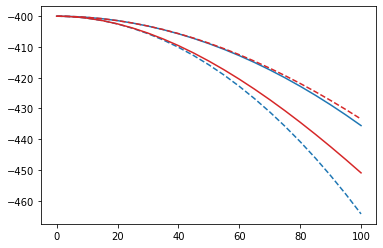

In [15]:
plt.plot(V_0_range, E_vGH1_B_1.real, color='tab:blue', linestyle='dashed')
plt.plot(V_0_range, E_vGH1_B_200.real, color='tab:blue')
plt.plot(V_0_range, E_pert1_B_1.real, color='tab:red')
plt.plot(V_0_range, E_pert1_B_200.real, color='tab:red', linestyle='dashed')
#plt.plot(V_0_range, E_pert3.real, color='tab:red')
#plt.plot(V_0_range, E_vGH3.real, color='tab:blue')

#plt.xscale('log')
#plt.yscale('log')

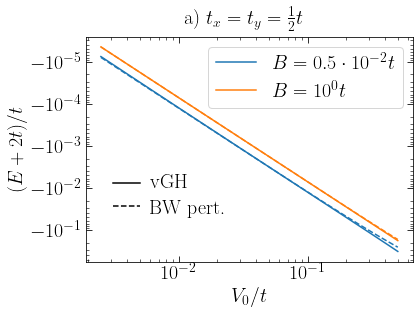

In [88]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'a) $t_x=t_y=\frac{1}{2}t$', fontsize=font_size)

axs.plot(V_0_range[1:]/t, E_to_plot(E_vGH1_B_1.real,t)[1:], color='tab:blue', linestyle='solid', label=r'$B = 0.5\cdot 10^{-2} t$')
axs.plot(V_0_range[1:]/t, E_to_plot(E_pert1_B_1.real,t)[1:], color='tab:blue', linestyle='dashed')

axs.plot(V_0_range[1:]/t, E_to_plot(E_vGH1_B_200.real,t)[1:], color='tab:orange', linestyle='solid', label=r'$B = 10^0 t$')
axs.plot(V_0_range[1:]/t, E_to_plot(E_pert1_B_200.real,t)[1:], color='tab:orange', linestyle='dashed')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$(E+2t)/t$', fontsize=font_size)

plt.xticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

axs.invert_yaxis()
axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

axs.plot(np.linspace(3.1e-3,5e-3,100), 0.75e-2*np.ones(100), linestyle='solid', color='black')
axs.plot(np.linspace(3.1e-3,5e-3,100), 0.27e-1*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-2), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-1), fontsize=font_size)

axs.legend(fontsize=font_size, loc=1)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.savefig('results/perturbation_theory/B_comp_tx_100_ty_100.svg', bbox_inches='tight')

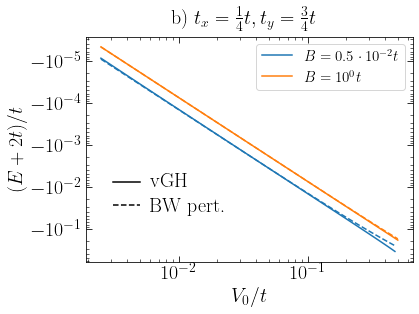

In [109]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'b) $t_x=\frac{1}{4}t,t_y=\frac{3}{4}t$', fontsize=font_size)

axs.plot(V_0_range[1:len(E_vGH2_B_1)-1]/t, E_to_plot(E_vGH2_B_1.real[1:len(E_vGH2_B_1)-1],t), color='tab:blue', linestyle='solid', label=r'$B = 0.5\cdot 10^{-2} t$')
axs.plot(V_0_range[1:len(E_vGH2_B_1)-1]/t, E_to_plot(E_pert2_B_1.real[1:len(E_vGH2_B_1)-1],t), color='tab:blue', linestyle='dashed')

axs.plot(V_0_range[1:]/t, E_to_plot(E_vGH2_B_200.real,t)[1:], color='tab:orange', linestyle='solid', label=r'$B = 10^0 t$')
axs.plot(V_0_range[1:]/t, E_to_plot(E_pert2_B_200.real,t)[1:], color='tab:orange', linestyle='dashed')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$(E+2t)/t$', fontsize=font_size)


plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

axs.invert_yaxis()
axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

axs.plot(np.linspace(3.1e-3,5e-3,100), 0.75e-2*np.ones(100), linestyle='solid', color='black')
axs.plot(np.linspace(3.1e-3,5e-3,100), 0.27e-1*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-2), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-1), fontsize=font_size)

axs.legend(fontsize=15, loc=1)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)
plt.savefig('results/perturbation_theory/B_comp_tx_50_ty_100.svg', bbox_inches='tight')

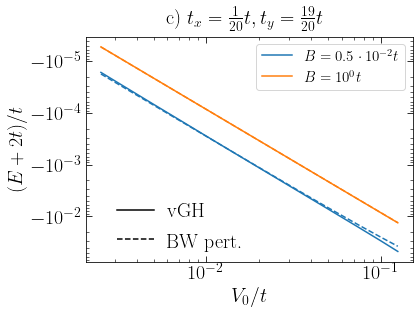

In [110]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'c) $t_x=\frac{1}{20}t,t_y=\frac{19}{20}t$', fontsize=font_size)

axs.plot(V_0_range[1:24]/t, E_to_plot(E_vGH3_B_1.real,t)[1:24], color='tab:blue', linestyle='solid', label=r'$B = 0.5\cdot 10^{-2} t$')
axs.plot(V_0_range[1:24]/t, E_to_plot(E_pert3_B_1.real,t)[1:24], color='tab:blue', linestyle='dashed')

axs.plot(V_0_range[1:24]/t, E_to_plot(E_vGH3_B_200.real,t)[1:24], color='tab:orange', linestyle='solid', label=r'$B = 10^0 t$')
axs.plot(V_0_range[1:24]/t, E_to_plot(E_pert3_B_200.real,t)[1:24], color='tab:orange', linestyle='dashed')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$(E+2t)/t$', fontsize=font_size)


plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

axs.invert_yaxis()
axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

axs.plot(np.linspace(3.1e-3,5e-3,100), 0.75e-2*np.ones(100), linestyle='solid', color='black')
axs.plot(np.linspace(3.1e-3,5e-3,100), 0.27e-1*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-2), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-1), fontsize=font_size)

axs.legend(fontsize=15, loc=1)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)
plt.savefig('results/perturbation_theory/B_comp_tx_10_ty_190.svg', bbox_inches='tight')

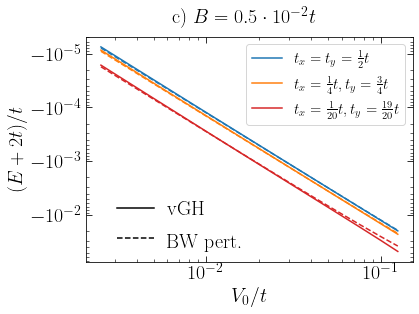

In [114]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'c) $B = 0.5\cdot 10^{-2}t$', fontsize=font_size)

axs.plot(V_0_range[1:24]/t, E_to_plot(E_vGH1_B_1.real,t)[1:24], color='tab:blue', linestyle='solid', label=r'$t_x=t_y=\frac{1}{2}t$')
axs.plot(V_0_range[1:24]/t, E_to_plot(E_pert1_B_1.real,t)[1:24], color='tab:blue', linestyle='dashed')

axs.plot(V_0_range[1:24]/t, E_to_plot(E_vGH2_B_1.real,t)[1:24], color='tab:orange', linestyle='solid', label=r'$t_x=\frac{1}{4}t,t_y=\frac{3}{4}t$')
axs.plot(V_0_range[1:24]/t, E_to_plot(E_pert2_B_1.real,t)[1:24], color='tab:orange', linestyle='dashed')

axs.plot(V_0_range[1:24]/t, E_to_plot(E_vGH3_B_1.real,t)[1:24], color='tab:red', linestyle='solid', label=r'$t_x=\frac{1}{20}t,t_y=\frac{19}{20}t$')
axs.plot(V_0_range[1:24]/t, E_to_plot(E_pert3_B_1.real,t)[1:24], color='tab:red', linestyle='dashed')


plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$(E+2t)/t$', fontsize=font_size)


plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

axs.invert_yaxis()
axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

axs.plot(np.linspace(3.1e-3,5e-3,100), 0.75e-2*np.ones(100), linestyle='solid', color='black')
axs.plot(np.linspace(3.1e-3,5e-3,100), 0.27e-1*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-2), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-1), fontsize=font_size)

axs.legend(fontsize=15, loc=1)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)
plt.savefig('results/perturbation_theory/sym_comp_B_0.01t.svg', bbox_inches='tight')

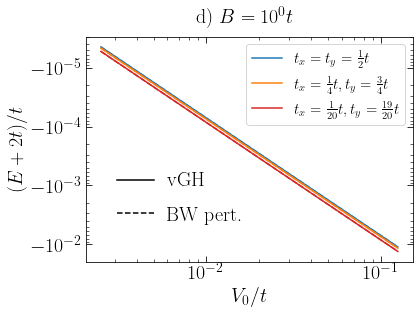

In [122]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'd) $B = 10^{0}t$', fontsize=font_size)

axs.plot(V_0_range[1:24]/t, E_to_plot(E_vGH1_B_200.real,t)[1:24], color='tab:blue', linestyle='solid', label=r'$t_x=t_y=\frac{1}{2}t$')
axs.plot(V_0_range[1:24]/t, E_to_plot(E_pert1_B_200.real,t)[1:24], color='tab:blue', linestyle='dashed')

axs.plot(V_0_range[1:24]/t, E_to_plot(E_vGH2_B_200.real,t)[1:24], color='tab:orange', linestyle='solid', label=r'$t_x=\frac{1}{4}t,t_y=\frac{3}{4}t$')
axs.plot(V_0_range[1:24]/t, E_to_plot(E_pert2_B_200.real,t)[1:24], color='tab:orange', linestyle='dashed')

axs.plot(V_0_range[1:24]/t, E_to_plot(E_vGH3_B_200.real,t)[1:24], color='tab:red', linestyle='solid', label=r'$t_x=\frac{1}{20}t,t_y=\frac{19}{20}t$')
axs.plot(V_0_range[1:24]/t, E_to_plot(E_pert3_B_200.real,t)[1:24], color='tab:red', linestyle='dashed')


plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$(E+2t)/t$', fontsize=font_size)

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

axs.invert_yaxis()
axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

axs.plot(np.linspace(3.1e-3,5e-3,100), 0.8e-3*np.ones(100), linestyle='solid', color='black')
axs.plot(np.linspace(3.1e-3,5e-3,100), 0.3e-2*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-3), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-2), fontsize=font_size)

axs.legend(fontsize=15, loc=1)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)
plt.savefig('results/perturbation_theory/sym_comp_B_t.svg', bbox_inches='tight')

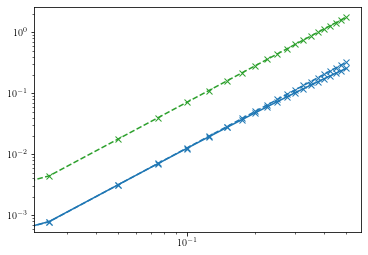

In [124]:
plt.plot(V_0_range/t, E_to_plot(E_pert1.real,t), marker='x', color='tab:blue', linestyle='solid', label=r'$t_x = 100, t_y = 100$')
plt.plot(V_0_range/t, E_to_plot(E_vGH1.real,t), marker='x', color='tab:blue', linestyle='dashed')
plt.plot(V_0_range/t, (1/(1*(1+4*t))**0.5)*V_0_range**2/t, marker='x', color='tab:green', linestyle='dashed')


plt.xscale('log')
plt.yscale('log')

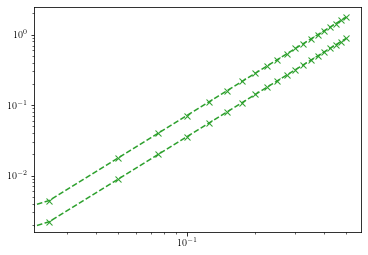

In [77]:
plt.plot(V_0_range/t, 2*(0.5*(1/(1*(1+4*200))**0.5)*(V_0_range)**2)/t, marker='x', color='tab:green', linestyle='dashed')
plt.plot(V_0_range/t, (0.5*(1/(1*(1+4*200))**0.5)*(V_0_range)**2)/t, marker='x', color='tab:green', linestyle='dashed')

plt.xscale('log')
plt.yscale('log')

In [19]:
V_0_range = np.linspace(0,10,3)

params["tol"] = 1e-8

params["tx"] = 100
params["ty"] = 100
t = params["tx"] + params["ty"]
E_pert1, E_vGH1 = get_energies(params,V_0_range)

print(E_pert1-E_vGH1)


vGH Calculations:
V0 = 0.0
V0 = 5.0
V0 = 10.0

Perturbative Calculations:
V0 = 0.0
V0 = 5.0
V0 = 10.0
[ 0.        +0.j -0.00675135+0.j  0.00912571+0.j]


### Effective Mass Calculations